
Bu notebook, kredi karti dolandiricilik tespiti icin iki farkli makine ogrenimi modeli uygular:
1. **K-Nearest Neighbors (KNN)** - Mesafe tabanli model
2. **Deep Learning - MLP (PyTorch)** - Cok katmanli yapay sinir agi

Her iki model de hiperparametre ayari ve kapsamli degerlendirme metrikleri icerir.

## 1. Kutuphanelerin Yuklenmesi

In [1]:
# Gerekli kutuphaneleri ice aktar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# GPU kontrolu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanilan cihaz: {device}")
print("Kutuphaneler basariyla yuklendi!")

Kullanilan cihaz: cpu
Kutuphaneler basariyla yuklendi!


## 2. Temizlenmis Verilerin Yuklenmesi
`data/processed/creditcard_clean.csv` dosyasindan onceden islenmis veriler yukleniyor

In [2]:
# Temizlenmis veri setini yukle
df = pd.read_csv('data/processed/creditcard_clean.csv')

print(f"Veri Seti Boyutu: {df.shape}")
print(f"\nSinif Dagilimi:")
print(df['Class'].value_counts())
print(f"\nDolandiricilik Orani: %{df['Class'].mean() * 100:.2f}")
df.head()

Veri Seti Boyutu: (283726, 33)

Sinif Dagilimi:
Class
0    283253
1       473
Name: count, dtype: int64

Dolandiricilik Orani: %0.17


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled,Time_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244200,-1.996823
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342584,-1.996823
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.158900,-1.996802
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.139886,-1.996802
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073813,-1.996781


## 3. Veri Hazirlama ve StandardScaler
KNN mesafe tabanli bir algoritma oldugu icin StandardScaler kullanmak zorunludur.

In [3]:
# Ozellikler ve hedef degiskeni ayir
X = df.drop('Class', axis=1)
y = df['Class']

# Verileri egitim ve test setlerine bol
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# StandardScaler uygula - KNN icin zorunlu!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Egitim seti boyutu: {X_train.shape[0]}")
print(f"Test seti boyutu: {X_test.shape[0]}")
print(f"\nEgitim seti sinif dagilimi:")
print(y_train.value_counts())
print(f"\nStandardScaler basariyla uygulandi!")

Egitim seti boyutu: 226980
Test seti boyutu: 56746

Egitim seti sinif dagilimi:
Class
0    226602
1       378
Name: count, dtype: int64

StandardScaler basariyla uygulandi!


## 4. Model 1: K-Nearest Neighbors (KNN) - Hiperparametre Ayarli

In [4]:
# KNN parametre izgarasini tanimla
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# KNN modelini baslat
knn_model = KNeighborsClassifier()

# GridSearchCV uygula
knn_search = GridSearchCV(
    knn_model,
    knn_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("KNN Hiperparametre Ayari ile Egitiliyor...")
print("NOT: StandardScaler kullanildi - mesafe tabanli algoritmalar icin zorunlu!")
knn_search.fit(X_train_scaled, y_train)

print(f"\nEn Iyi Parametreler: {knn_search.best_params_}")
print(f"En Iyi CV F1 Skoru: {knn_search.best_score_:.4f}")

KNN Hiperparametre Ayari ile Egitiliyor...
NOT: StandardScaler kullanildi - mesafe tabanli algoritmalar icin zorunlu!
Fitting 3 folds for each of 30 candidates, totalling 90 fits

En Iyi Parametreler: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
En Iyi CV F1 Skoru: 0.8481


In [5]:
# En iyi KNN modelini al
best_knn = knn_search.best_estimator_

# Tahminleri yap
knn_pred = best_knn.predict(X_test_scaled)
knn_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

# Metrikleri hesapla
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_auc = roc_auc_score(y_test, knn_pred_proba)

print("=" * 50)
print("KNN SONUCLARI")
print("=" * 50)
print(f"Dogruluk (Accuracy):  {knn_accuracy:.4f}")
print(f"Kesinlik (Precision): {knn_precision:.4f}")
print(f"Duyarlilik (Recall):  {knn_recall:.4f}")
print(f"F1-Skoru:             {knn_f1:.4f}")
print(f"AUC:                  {knn_auc:.4f}")
print("\nSiniflandirma Raporu:")
print(classification_report(y_test, knn_pred, target_names=['Normal', 'Dolandiricilik']))

KNN SONUCLARI
Dogruluk (Accuracy):  0.9995
Kesinlik (Precision): 0.9444
Duyarlilik (Recall):  0.7158
F1-Skoru:             0.8144
AUC:                  0.8894

Siniflandirma Raporu:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00     56651
Dolandiricilik       0.94      0.72      0.81        95

      accuracy                           1.00     56746
     macro avg       0.97      0.86      0.91     56746
  weighted avg       1.00      1.00      1.00     56746



## 5. Model 2: Deep Learning - MLP (PyTorch)
Cok Katmanli Yapay Sinir Agi (Multi-Layer Perceptron)

In [6]:
# MLP Model Sinifi Tanimla
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Gizli katmanlar
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Cikis katmani
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

print("MLP Model sinifi tanimlandi!")

MLP Model sinifi tanimlandi!


In [7]:
# PyTorch icin veri hazirligi
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1).to(device)

# DataLoader olustur
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Batch boyutu: {batch_size}")
print(f"Toplam batch sayisi: {len(train_loader)}")

Batch boyutu: 256
Toplam batch sayisi: 887


In [8]:
# Hiperparametreler
input_size = X_train_scaled.shape[1]
hidden_sizes = [128, 64, 32]  # Gizli katman noron sayilari
learning_rate = 0.001
epochs = 50
dropout_rate = 0.3

# Modeli olustur
mlp_model = MLPClassifier(input_size, hidden_sizes, dropout_rate).to(device)

# Dengesiz veri icin agirlikli kayip fonksiyonu
pos_weight = torch.tensor([len(y_train[y_train==0]) / len(y_train[y_train==1])]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)

print("Model Mimarisi:")
print(mlp_model)
print(f"\nHiperparametreler:")
print(f"  - Ogrenme orani: {learning_rate}")
print(f"  - Epoch sayisi: {epochs}")
print(f"  - Batch boyutu: {batch_size}")
print(f"  - Gizli katmanlar: {hidden_sizes}")
print(f"  - Dropout orani: {dropout_rate}")

Model Mimarisi:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Hiperparametreler:
  - Ogrenme orani: 0.001
  - Epoch sayisi: 50
  - Batch boyutu: 256
  - Gizli katmanlar: [128, 64, 32]
  - Dropout orani: 0.3


In [9]:
# Modeli egit
print("MLP Modeli Egitiliyor...")
print("=" * 50)

train_losses = []
mlp_model.train()

for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # Ileri yayilim
        outputs = mlp_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Geri yayilim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Kayip: {avg_loss:.4f}")

print("\nEgitim tamamlandi!")

MLP Modeli Egitiliyor...
Epoch [10/50], Kayip: 0.0023
Epoch [20/50], Kayip: 0.0018
Epoch [30/50], Kayip: 0.0014
Epoch [40/50], Kayip: 0.0011
Epoch [50/50], Kayip: 0.0012

Egitim tamamlandi!


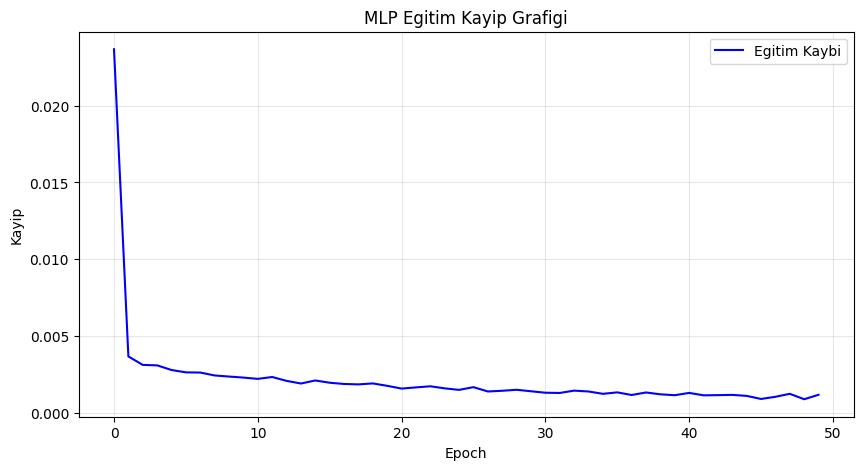

In [10]:
# Egitim kayip grafigi
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Egitim Kaybi', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Kayip')
plt.title('MLP Egitim Kayip Grafigi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('mlp_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# MLP tahminleri
mlp_model.eval()
with torch.no_grad():
    mlp_pred_proba = mlp_model(X_test_tensor).cpu().numpy().flatten()
    mlp_pred = (mlp_pred_proba >= 0.5).astype(int)

# Metrikleri hesapla
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred)
mlp_auc = roc_auc_score(y_test, mlp_pred_proba)

print("=" * 50)
print("MLP (DEEP LEARNING) SONUCLARI")
print("=" * 50)
print(f"Dogruluk (Accuracy):  {mlp_accuracy:.4f}")
print(f"Kesinlik (Precision): {mlp_precision:.4f}")
print(f"Duyarlilik (Recall):  {mlp_recall:.4f}")
print(f"F1-Skoru:             {mlp_f1:.4f}")
print(f"AUC:                  {mlp_auc:.4f}")
print("\nSiniflandirma Raporu:")
print(classification_report(y_test, mlp_pred, target_names=['Normal', 'Dolandiricilik']))

MLP (DEEP LEARNING) SONUCLARI
Dogruluk (Accuracy):  0.9995
Kesinlik (Precision): 0.9714
Duyarlilik (Recall):  0.7158
F1-Skoru:             0.8242
AUC:                  0.9515

Siniflandirma Raporu:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00     56651
Dolandiricilik       0.97      0.72      0.82        95

      accuracy                           1.00     56746
     macro avg       0.99      0.86      0.91     56746
  weighted avg       1.00      1.00      1.00     56746



## 6. ROC Egrileri Karsilastirmasi

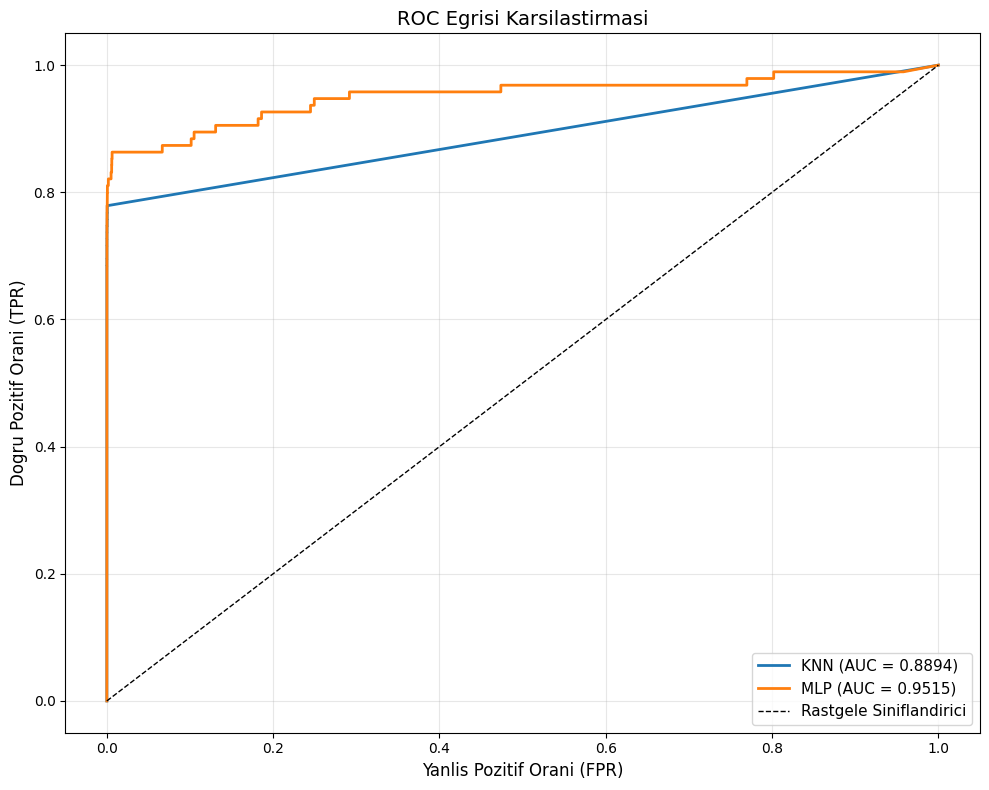

ROC Egrisi 'roc_curves.png' olarak kaydedildi


In [12]:
# ROC egrilerini hesapla
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_pred_proba)
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_pred_proba)

# ROC egrilerini ciz
plt.figure(figsize=(10, 8))

plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.4f})', linewidth=2)
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP (AUC = {mlp_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Siniflandirici', linewidth=1)

plt.xlabel('Yanlis Pozitif Orani (FPR)', fontsize=12)
plt.ylabel('Dogru Pozitif Orani (TPR)', fontsize=12)
plt.title('ROC Egrisi Karsilastirmasi', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC Egrisi 'roc_curves.png' olarak kaydedildi")

## 7. Karisiklik Matrisleri

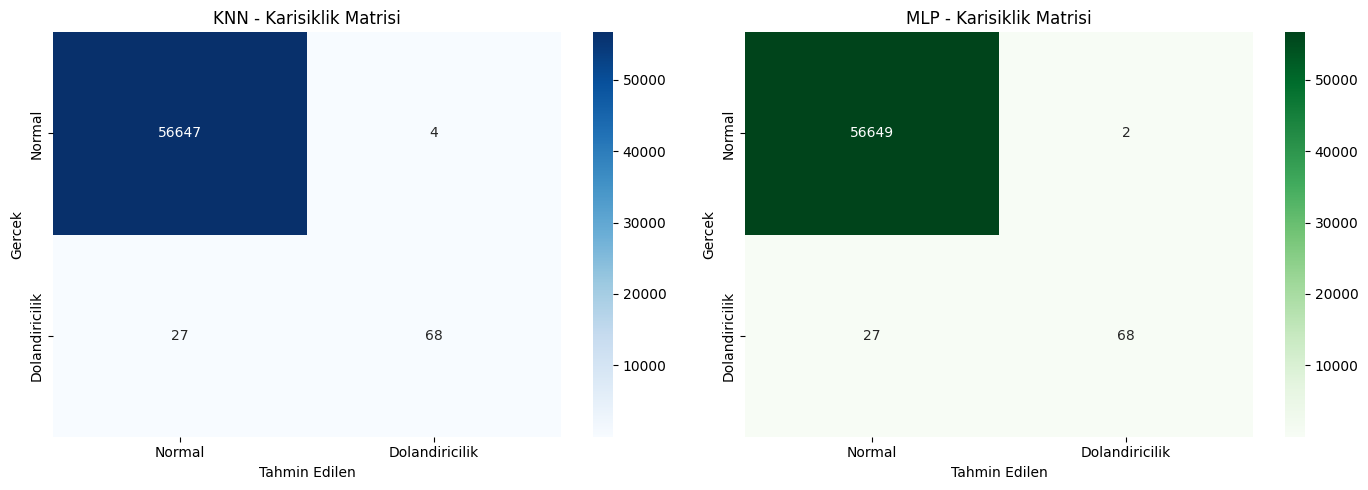

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KNN Karisiklik Matrisi
knn_cm = confusion_matrix(y_test, knn_pred)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Dolandiricilik'],
            yticklabels=['Normal', 'Dolandiricilik'])
axes[0].set_title('KNN - Karisiklik Matrisi', fontsize=12)
axes[0].set_xlabel('Tahmin Edilen')
axes[0].set_ylabel('Gercek')

# MLP Karisiklik Matrisi
mlp_cm = confusion_matrix(y_test, mlp_pred)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Normal', 'Dolandiricilik'],
            yticklabels=['Normal', 'Dolandiricilik'])
axes[1].set_title('MLP - Karisiklik Matrisi', fontsize=12)
axes[1].set_xlabel('Tahmin Edilen')
axes[1].set_ylabel('Gercek')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Sonuc Karsilastirma Tablosu

In [14]:
# Sonuc DataFrame olustur
results_df = pd.DataFrame({
    'Model': ['KNN', 'MLP (Deep Learning)'],
    'Dogruluk': [knn_accuracy, mlp_accuracy],
    'Kesinlik': [knn_precision, mlp_precision],
    'Duyarlilik': [knn_recall, mlp_recall],
    'F1-Skoru': [knn_f1, mlp_f1],
    'AUC': [knn_auc, mlp_auc]
})

# Degerleri yuvarla
results_df = results_df.round(4)

# Sonuclari goster
print("=" * 70)
print("MODEL KARSILASTIRMA SONUCLARI")
print("=" * 70)
print(results_df.to_string(index=False))

# Sonuclari CSV dosyasina kaydet
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nSonuclar 'model_comparison_results.csv' dosyasina kaydedildi")

MODEL KARSILASTIRMA SONUCLARI
              Model  Dogruluk  Kesinlik  Duyarlilik  F1-Skoru    AUC
                KNN    0.9995    0.9444      0.7158    0.8144 0.8894
MLP (Deep Learning)    0.9995    0.9714      0.7158    0.8242 0.9515

Sonuclar 'model_comparison_results.csv' dosyasina kaydedildi


## 9. En Iyi Model Analizi

In [15]:
# F1-Skoruna gore en iyi modeli belirle
best_model_idx = results_df['F1-Skoru'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print("=" * 70)
print("SON ANALIZ")
print("=" * 70)
print(f"\nEN IYI MODEL: {best_model_name}")
print(f"\nEn Iyi Model Metrikleri:")
print(results_df.loc[best_model_idx].to_string())

print("\n" + "-" * 70)
print("ANALIZ NOTLARI:")
print("-" * 70)
print("""
1. KNN ve MLP Karsilastirmasi:
   - KNN: Mesafe tabanli basit algoritma, StandardScaler zorunlu
   - MLP: Derin ogrenme modeli, karmasik oruntuleri ogrenebilir

2. StandardScaler Etkisi:
   - KNN mesafe hesaplamasi yaptigindan olcekleme kritik oneme sahip
   - Olcekleme yapilmazsa buyuk degerli ozellikler baskın olur

3. Dengesiz Veri Seti:
   - Dolandiricilik vakalari cok nadir (%0.17)
   - F1-Skoru ve AUC daha guvenilir metriklerdir
   - Dogruluk yaniltici olabilir

4. Asiri Ogrenme/Yetersiz Ogrenme:
   - MLP: Dropout katmanlari asiri ogrenmeyi onler
   - KNN: k degeri cok kucukse asiri ogrenme riski

5. Oneriler:
   - Dolandiricilik tespitinde Duyarlilik (Recall) onemli
   - MLP daha karmasik oruntuleri yakalayabilir
   - KNN buyuk veri setlerinde yavas olabilir
""")

SON ANALIZ

EN IYI MODEL: MLP (Deep Learning)

En Iyi Model Metrikleri:
Model         MLP (Deep Learning)
Dogruluk                   0.9995
Kesinlik                   0.9714
Duyarlilik                 0.7158
F1-Skoru                   0.8242
AUC                        0.9515

----------------------------------------------------------------------
ANALIZ NOTLARI:
----------------------------------------------------------------------

1. KNN ve MLP Karsilastirmasi:
   - KNN: Mesafe tabanli basit algoritma, StandardScaler zorunlu
   - MLP: Derin ogrenme modeli, karmasik oruntuleri ogrenebilir

2. StandardScaler Etkisi:
   - KNN mesafe hesaplamasi yaptigindan olcekleme kritik oneme sahip
   - Olcekleme yapilmazsa buyuk degerli ozellikler baskın olur

3. Dengesiz Veri Seti:
   - Dolandiricilik vakalari cok nadir (%0.17)
   - F1-Skoru ve AUC daha guvenilir metriklerdir
   - Dogruluk yaniltici olabilir

4. Asiri Ogrenme/Yetersiz Ogrenme:
   - MLP: Dropout katmanlari asiri ogrenmeyi onler
   - 

---
## Ozet

Bu notebook sunlari uyguladi:
1. K-Nearest Neighbors (KNN) - Hiperparametre Ayarli (n_neighbors, weights, metric)
2. MLP Deep Learning (PyTorch) - Cok katmanli yapay sinir agi
3. StandardScaler - Mesafe tabanli algoritmalar icin zorunlu
4. Tam degerlendirme metrikleri (Dogruluk, Kesinlik, Duyarlilik, F1-Skoru, AUC)
5. Her iki model icin ROC Egrileri
6. Karisiklik Matrisleri
7. Tum metriklerle karsilastirma tablosu

**Veri Kaynagi:** `data/processed/creditcard_clean.csv` (Data_Cleaning.ipynb dosyasinda on islenmis)